In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE


In [17]:
# Load data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR' as columns and 'label' as target column

data = pd.read_csv('../dataset_tables/final_dataset.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      251 non-null    object
 1   split   251 non-null    object
 2   Label   251 non-null    bool  
 3   NDVI    251 non-null    object
 4   NBR     251 non-null    object
 5   NDWI    251 non-null    object
 6   NDBI    251 non-null    object
 7   RGB     251 non-null    object
dtypes: bool(1), object(7)
memory usage: 14.1+ KB


In [18]:
# Randomly drop 190 rows where label is 0
data = data.drop(data[data.Label == 0].sample(190, random_state=1).index)

In [19]:
def convert_string_to_list(item):
    if isinstance(item, (int, float)):
        return [item]
    s = str(item)
    s = s.replace('nan', '0')
    lst = ast.literal_eval(s)
    return lst

data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
data['NDWI'] = data['NDWI'].apply(lambda x: convert_string_to_list(x))

In [20]:
# Combine NDVI and NDWI data into a single feature array
X = np.array([np.ravel(ndvi + ndwi) for ndvi, ndwi in zip(data['NDVI'], data['NDWI'])])
X = np.nan_to_num(X)

# Labels
y = data['Label'].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [21]:
# Apply SMOTE to deal with class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [22]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [23]:
for i in range(len(X)):
    print(X[i])

[ 0.60331858  0.41760847  0.3545447  ... -0.30681751 -0.31184443
 -0.29825805]
[ 0.41767032  0.23446855  0.11592291 ... -0.08731844 -0.27310941
 -0.25923043]
[ 0.33272452  0.18827997  0.18282238 ... -0.03340902  0.00441046
 -0.0031836 ]
[ 0.50873469  0.50530173  0.33406787 ...  0.03577382 -0.04313533
 -0.07115356]
[ 0.75857934  0.68695925  0.73336144 ... -0.61710927 -0.6175118
 -0.64118194]
[ 0.40702504  0.50437515  0.5622763  ... -0.06020712 -0.12847891
 -0.13444414]
[ 0.5312659   0.46114016  0.49824539 ... -0.25057905 -0.38144523
 -0.40959688]
[ 0.36843349 -0.06521698  0.64037915 ... -0.28274601 -0.2856083
 -0.27313807]
[ 0.73965736  0.71085592  0.69210087 ... -0.41459616 -0.42814125
 -0.42729626]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.4895514   0.40703136  0.4162904  ... -0.02827155 -0.09287851
 -0.05254952]
[ 0.25114152  0.18164969  0.18178905 ... -0.21437984 -0.20497164
 -0.23702165]
[0.69443204 0.51923945 0.55318891 ... 0.48898636 0.48487616 0

In [24]:
# Fine tune gamma and C range for RBF kernel
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


The best parameters are {'C': 10.0, 'gamma': 0.01} with a score of 0.91


In [25]:
# Classifier used: Radial Basis Function (RBF)
# it can combine multiple polynomial kernels multiple times of different degrees to
# project the non-linearly separable data into higher dimensional space

# gamma: https://www.ibm.com/docs/sr/spss-modeler/18.0.0?topic=node-svm-expert-options
# C: https://vitalflux.com/svm-rbf-kernel-parameters-code-sample/

# Train SVM model with best parameters
model = svm.SVC(kernel='rbf', gamma=grid.best_params_['gamma'], C=grid.best_params_['C']).fit(X_train, y_train)


In [26]:
# Calculate model efficiency

y_pred = model.predict(X_test)


In [27]:
# Calculate model evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred, average='macro')
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Mean Average Precision: {average_precision:.4f}")
print(f"F1-score: {f1_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7037
Precision: 0.8000
Recall: 0.7333
Mean Average Precision: 0.7630
F1-score: 0.7652

Classification Report:
              precision    recall  f1-score   support

       False       0.60      1.00      0.75        12
        True       1.00      0.47      0.64        15

    accuracy                           0.70        27
   macro avg       0.80      0.73      0.69        27
weighted avg       0.82      0.70      0.69        27


Confusion Matrix:
[[12  0]
 [ 8  7]]


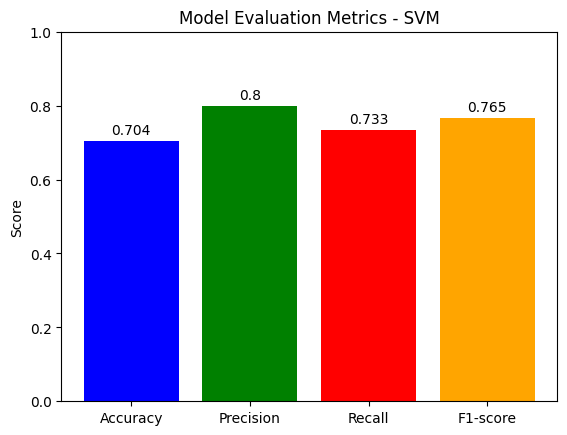

In [28]:
# Visualize the model evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1_score]

bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

plt.ylabel('Score')
plt.title('Model Evaluation Metrics - SVM')
plt.ylim(0, 1)
plt.show()
